# Тематическое моделирование при помощи LDA

In [ ]:
%%capture
!pip install sklearn
%pip install pyldavis 
!pip install pymorphy3

In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, train_test_split

import re
import pymorphy3
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora

import pyLDAvis.lda_model

from tqdm import tqdm

import pickle

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
RANDOM_STATE=2024

In [4]:
df = pd.read_csv('/kaggle/input/mail-news/all_news')

In [5]:
df.head()

,Unnamed: 0,Article Text
0,0,Костюм Снежинки В качестве основы для костюма ...
1,1,Если ребенок верит в сказку хотя бы до десяти ...
2,2,Подарки до 1 000 рублей Наборы для создания сн...
3,3,Чаще практикуйте контакт кожа к коже Период но...
4,4,"На календаре почти середина декабря, и знамени..."


In [6]:
df.shape

(66103, 2)

In [7]:
morph = pymorphy3.MorphAnalyzer()

In [8]:
def preprocess_text(data, stopwords=stopwords.words("russian")):
    text = re.sub("ё", "е", data.lower())
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^а-яА-Я\s]+", "", text)
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords]
    text = [w for w in text if len(w) >= 3]
    return ' '.join(text)

def lemmatization_text(data, morph=morph):
    result = ' '.join([morph.parse(x)[0].normal_form for x in data.split()])
    return result

def get_result(data, morph=morph, stopwords=stopwords.words("russian")):
    if data is not np.NaN:
        result = preprocess_text(data)
        result = lemmatization_text(result)
        return result
    return ''

In [9]:
X = df["Article Text"]

In [10]:
%%time
X_new = [get_result(x) for x in X]

CPU times: user 1h 22min 54s, sys: 1.15 s, total: 1h 22min 55s
Wall time: 1h 23min 1s


In [11]:
X_new = [x for x in X_new if x not in [None, '']]

In [12]:
with open("preprocess_article", "wb") as f:
    pickle.dump(X_new, f)

In [14]:
vector_ben = CountVectorizer(
    analyzer='word',
    min_df=10,
    ngram_range=(2, 3),
    stop_words=stopwords.words("russian")
)
train_vec_ben = vector_ben.fit_transform(X_new)

In [57]:
test_vec_ben = vector_ben.transform(X_test_new)

In [37]:
vector_ben.get_feature_names_out().shape

(137107,)

In [33]:
lda_model_ben = LatentDirichletAllocation(
    learning_method='online',
    random_state=RANDOM_STATE,
    n_components=12
)
lda_model_ben.fit(train_vec_ben)
print(lda_model_ben)

LatentDirichletAllocation(learning_method='online', n_components=12,
                          random_state=2024)


In [ ]:
lda_model_ben

In [34]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model_ben,
                                train_vec_ben,
                                vector_ben,
                                mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.056641 -11.015394       1        1  11.463159
0      -8.443432  -1.762185       2        1  10.687710
1     -33.416672   4.584054       3        1  10.300092
7      34.079563  17.021923       4        1   9.911243
5      12.972886   2.058112       5        1   9.863818
3      -5.821599  44.612297       6        1   9.823553
8     -21.426924 -20.909697       7        1   9.596197
9       6.530515 -22.879282       8        1   7.295007
4     -31.440722  32.772923       9        1   7.292270
10    -12.395537  19.656672      10        1   6.435941
11      9.039674  23.448540      11        1   4.291808
6      22.175638  42.476662      12        1   3.039204, topic_info=                       Term         Freq        Total Category  logprob  \
25641          главный роль  5732.000000  5732.000000  Default  30.0000   
112550      перейти магазин  4518.000000  4518.000000  Default  29.0000   
102656  опубликовать журнал  4860.000000  4860.000000  Default  28.0000   
106472         отзыв писать  4196.000000  4196.000000  Default  27.0000   
165020       смотреть отзыв  3809.000000  3809.000000  Default  26.0000   
...                     ...          ...          ...      ...      ...   
176819       столовая ложка   249.107974   286.531608  Topic12  -6.6955   
101573      оливковый масло   316.658314   431.755573  Topic12  -6.4556   
146029   растительный масло   289.646796   666.870541  Topic12  -6.5447   
113635         писать отзыв   279.914856  1185.470693  Topic12  -6.5789   
156870            свой рука   238.394892   554.451145  Topic12  -6.7395   

        loglift  
25641   30.0000  
112550  29.0000  
102656  28.0000  
106472  27.0000  
165020  26.0000  
...         ...  
176819   3.3536  
101573   3.1835  
146029   2.6596  
113635   2.0502  
156870   2.6495  

[626 rows x 6 columns], token_table=        Topic      Freq                Term
term                                       
222         3  0.999599  автор исследование
328         1  0.006019        автор проект
328        11  0.991697        автор проект
338         3  0.999142        автор работа
662        12  0.996019      академия наука
...       ...       ...                 ...
206599     11  0.196772         это сделать
206599     12  0.023828         это сделать
208191      6  0.861799          январь год
208191      9  0.137630          январь год
208513     12  0.996016     ёлочный игрушка

[1054 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 8, 6, 4, 9, 10, 5, 11, 12, 7])

'Здоровье': 2, 5, 8; 'Дом и дети(семья)': 10, 7;   'Премьера, знаменитости, кино': 11, 1, 4, 12, 9; 'Интересные исследования': 3, 'Актуальные новости': 6

In [93]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [96]:
feature_names = vector_ben.get_feature_names_out()

IndexError: index 10 is out of bounds for axis 0 with size 10

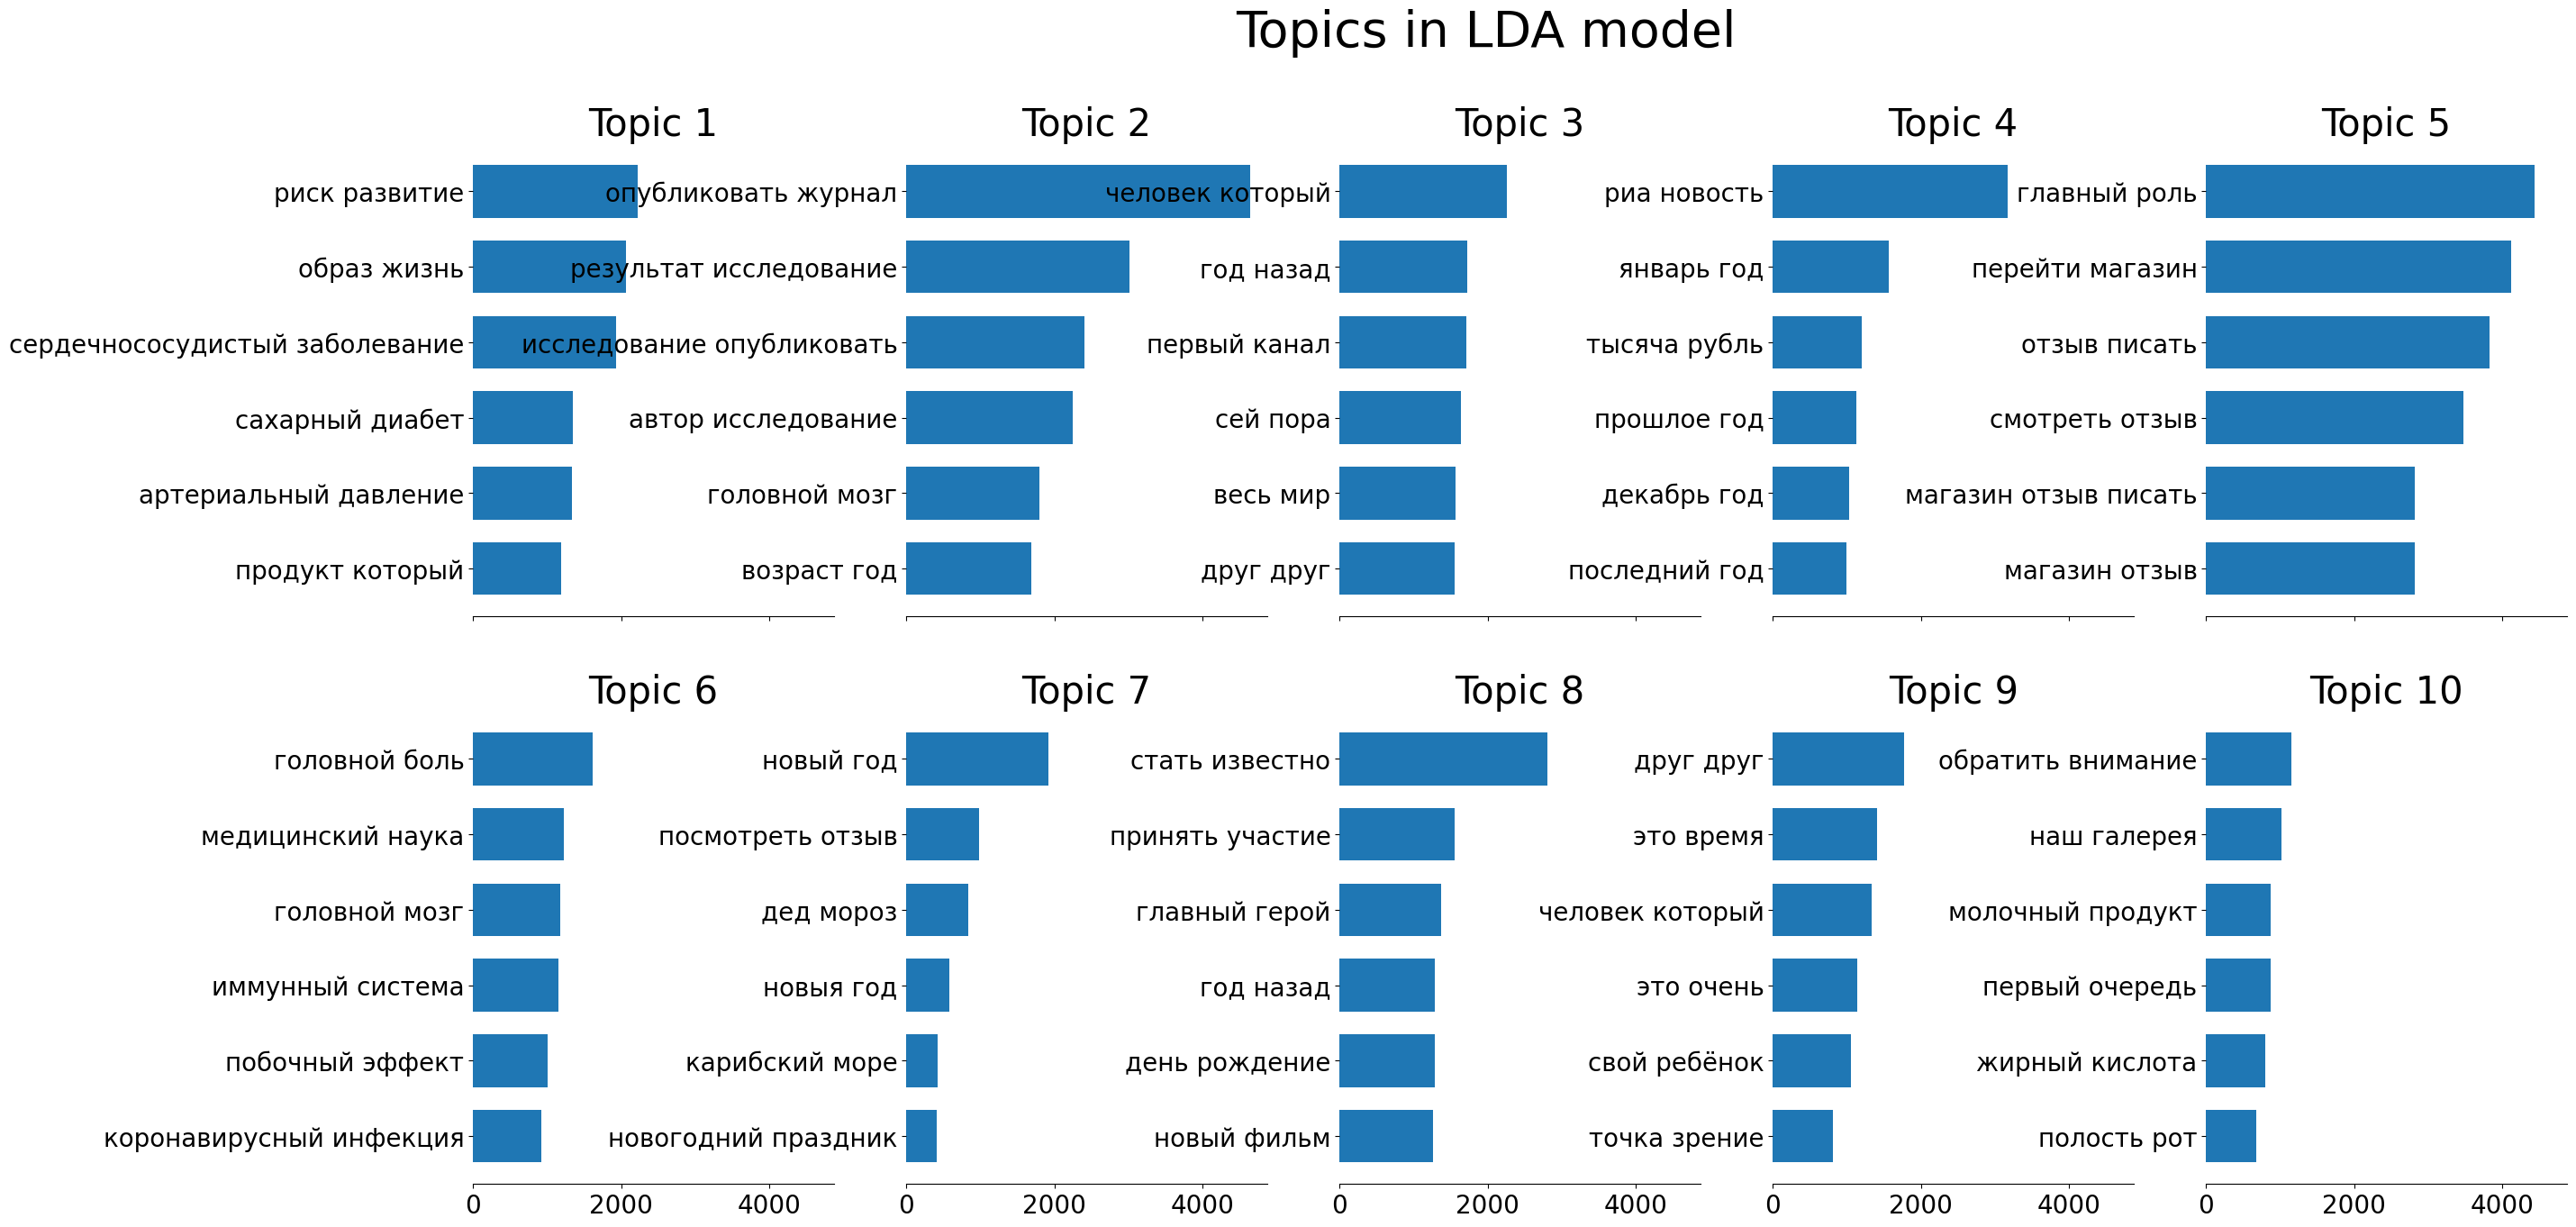

In [100]:
plot_top_words(lda_model_ben, feature_names, 6, "Topics in LDA model")

In [ ]:
t = {'Премьера, знаменитости, кино': 0, 'Здоровье': 1, 'Дом и дети(семья)': 2,
     'Интересные исследования': 3, 'Актуальные новости': 4}

In [ ]:
d = {1 : 0, 2: 1, 3: 3,
     4: 0, 5: 1, 6: 4,
     7: 2, 8: 1 , 9: 0, 
     10: 2, 11: 0, 12: 0}

In [87]:
d_name = {1 : 'Премьера, знаменитости, кино', 2: 'Здоровье', 3: 'Интересные исследования',
     4: 'Премьера, знаменитости, кино', 5: 'Здоровье', 6: 'Актуальные новости',
     7: 'Дом и дети(семья)', 8: 'Здоровье' , 9: 'Премьера, знаменитости, кино', 
     10: 'Дом и дети(семья)', 11: 'Премьера, знаменитости, кино', 12: 'Премьера, знаменитости, кино'}

In [70]:
topic_proba = lda_model_ben.transform(train_vec_ben)
topic = []
for proba in topic_proba:
    topic.append(proba.argmax() + 1)

In [72]:
df['topic'] = topic
df['num_topic'] = df['topic'].apply(lambda x: d[x])
df['name_topic'] = df['topic'].apply(lambda x: d_name[x])

In [89]:
df.head()

,Unnamed: 0,Article Text,topic,name_topic,num_topic
0,0,Костюм Снежинки В качестве основы для костюма ...,10,Дом и дети(семья),2
1,1,Если ребенок верит в сказку хотя бы до десяти ...,3,Интересные исследования,3
2,2,Подарки до 1 000 рублей Наборы для создания сн...,9,"Премьера, знаменитости, кино",0
3,3,Чаще практикуйте контакт кожа к коже Период но...,10,Дом и дети(семья),2
4,4,"На календаре почти середина декабря, и знамени...",8,Здоровье,1


In [90]:
df.to_csv('text_topic')